In [25]:
BASE_PATH = './'

# Image Utils

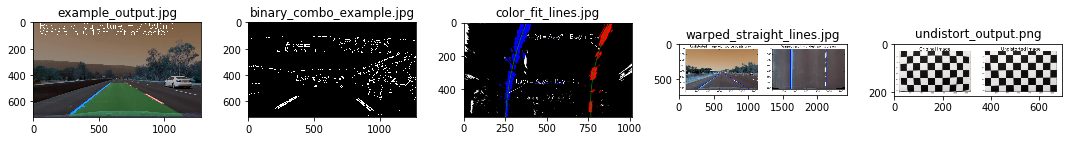

In [26]:
import numpy as np
import cv2
import glob
import math
from pathlib import Path 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_images(images, cols=5):
  num_images = len(images)
  if num_images > 0 and num_images < cols:
    cols = num_images 
  #print("rows: " + str(num_images/cols))
  rows = math.ceil(num_images/cols)
  #print("cols: " + str(cols) + " rows: " + str(rows))
  fig, axes = plt.subplots(rows, cols, figsize=(15,10))
  fig.set_tight_layout(True)
  indexes = range(cols * rows)
  for ax, index in zip(axes.flat, indexes):
    if index < num_images:
      #print(type(images[index]))
      if isinstance(images[index], tuple):
        name, image = images[index]
        ax.imshow(image)
        ax.set_title(name)
      else:
        ax.imshow(images[index])
        ax.set_title(str(index))

def open_images_from_paths_with_names(paths=[]):
  images = list(map(lambda path: (Path(path).name, cv2.imread(path)), paths))
  return images

def open_images_from_paths(paths=[]):
  images = list(map(lambda path: (cv2.imread(path)), paths))
  return images

def plot_images_from_paths(paths=[]):
  images = open_images_from_paths_with_names(paths)
  plot_images(images)

def get_all_image_paths(path):
  paths = glob.glob(path + "/*.jpg")
  _paths = glob.glob(path + "/*.png")
  paths.extend(_paths)
  return paths

#image_paths = glob.glob(BASE_PATH + 'camera_cal/c*.jpg')
#image_paths = glob.glob(BASE_PATH + 'examples/*.jpg')
#print(image_paths)
image_paths = get_all_image_paths(BASE_PATH + 'examples')
plot_images_from_paths(image_paths)


# Setup

In [27]:
import os
import errno

CACHE_DIR = BASE_PATH + 'cache'

def setup():
  try:
    os.makedirs(CACHE_DIR)
  except OSError as exc:
    if exc.errno != errno.EEXIST:
      raise

setup()

# Calibrate Camera

In [28]:
import numpy as np
import cv2
import glob
import os
import pickle

CHESS_BOARD_SHAPE = (9,6)

CAMERA_CAL_PATH = BASE_PATH + 'camera_cal'

def calibrate_camera_from_images(images):
  objpoints = [] # 3d points in real world space
  imgpoints = [] # 2d points in image plane.

  x_pts = CHESS_BOARD_SHAPE[0]
  y_pts = CHESS_BOARD_SHAPE[1]
  objp = np.zeros((x_pts * y_pts,3), np.float32)
  objp[:,:2] = np.mgrid[0:x_pts, 0:y_pts].T.reshape(-1,2)

  for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, CHESS_BOARD_SHAPE, None)

    # If found, add object points, image points
    if ret == True:
      objpoints.append(objp)
      imgpoints.append(corners)

  # Do camera calibration given object points and image points
  image_dimensions = (image.shape[1], image.shape[0])
  ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                     image_dimensions,
                                                     None, None)
  calib = {}
  calib["ret"] = ret
  calib["mtx"] = mtx
  calib["dist"] = dist
  calib["rvecs"] = rvecs
  calib["tvecs"] = tvecs

  return calib


def calibrate_camera(path=CAMERA_CAL_PATH):
  calibration = CACHE_DIR + "/calibration.p"

  if os.path.isfile(calibration):
    print("Calibration cache found")
    calib = pickle.load(open(calibration, "rb"))
  else:
    paths = get_all_image_paths(path)
    images = open_images_from_paths(paths)

    calib = calibrate_camera_from_images(images)
    # Save the camera calibration in a pickle file
    pickle.dump(calib, open(calibration, "wb"))

  return calib


# Distortion Correction

In [29]:
calib = calibrate_camera()

def undistort_image(image):
    image = cv2.undistort(image, calib["mtx"], calib["dist"], None, calib["mtx"])
    return image

# Perspective/Warp Transform

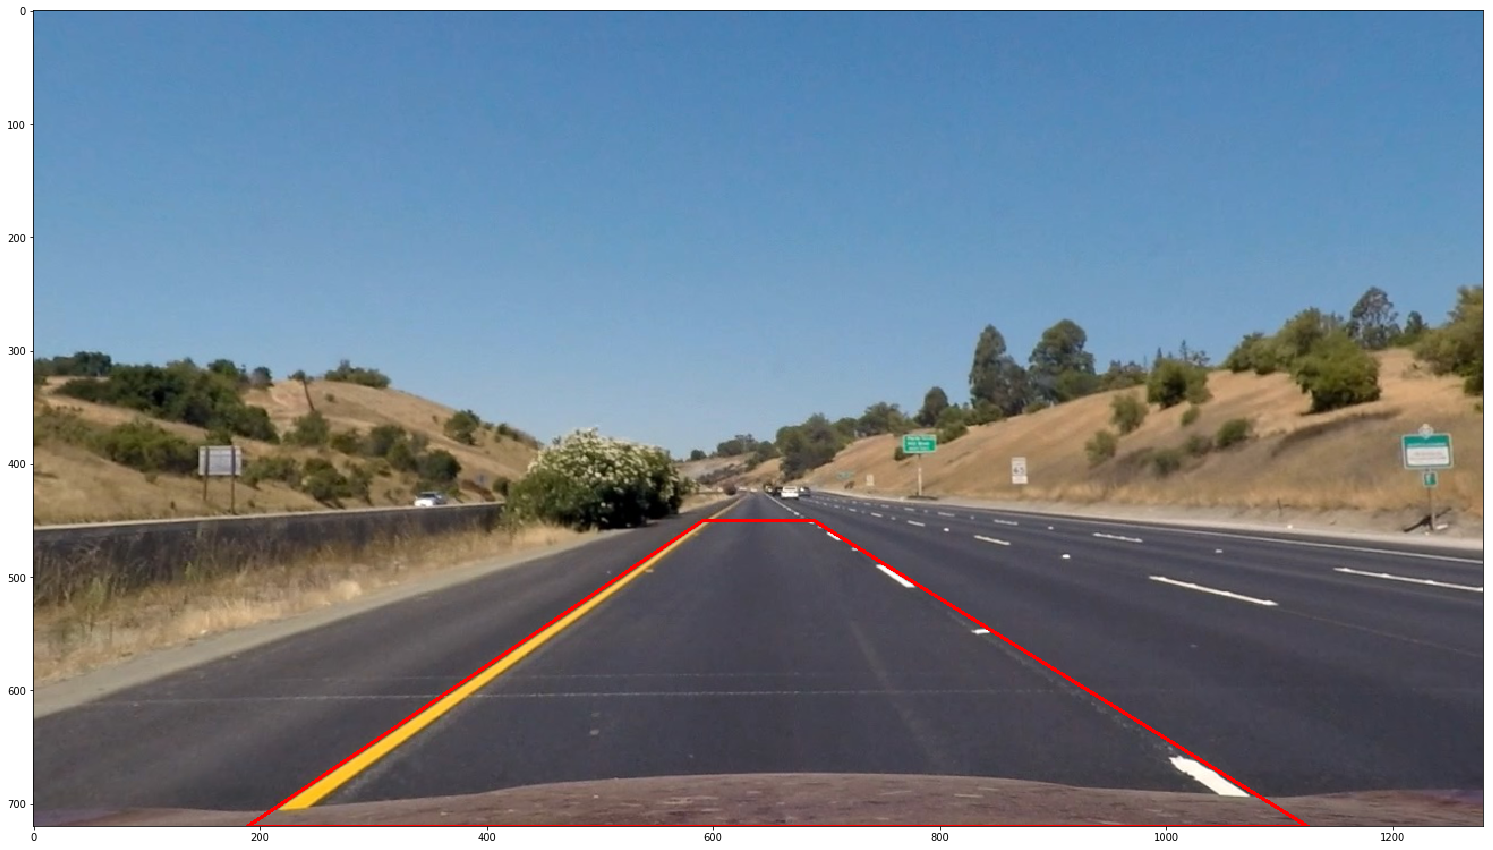

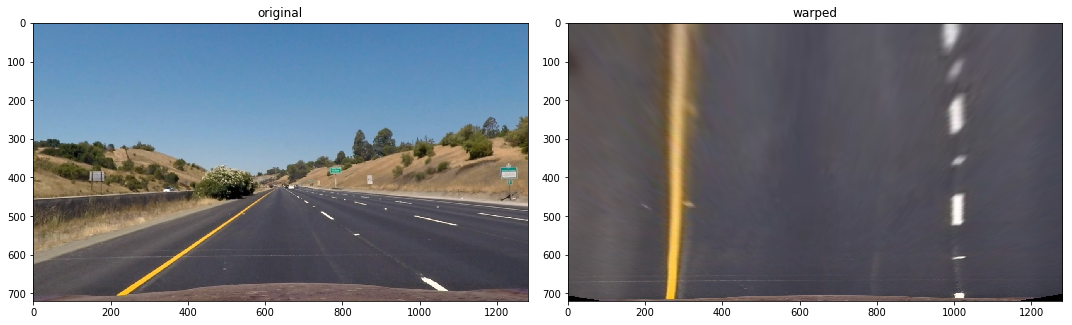

In [30]:
PERSPECTIVE_TRANSFORM_BASE_IMAGE = BASE_PATH + 'test_images/straight_lines1.jpg'

def create_perspective_transform_mappings(image):
  ud_image = undistort_image(image)
  #bottom_left = (185, 720)
  bottom_left = (189, 720)
  #top_left = (604, 440)
  top_left = (591, 450)
  #top_left = (576, 460)
  #top_left = (562, 470)
  #top_right = (676, 440)
  top_right = (689, 450)
  #top_right = (705, 460)
  #top_right = (722, 470)
  #bottom_right = (1130, 720)
  bottom_right = (1125, 720)

  lcolor = [255, 0, 0]
  lwidth = 2
  copy = ud_image.copy()
  cv2.line(copy, bottom_left, top_left, lcolor, lwidth)
  cv2.line(copy, top_left, top_right, lcolor, lwidth)
  cv2.line(copy, top_right, bottom_right, lcolor, lwidth)
  cv2.line(copy, bottom_right, bottom_left, lcolor, lwidth)
  fig, ax = plt.subplots(figsize=(30, 15))
  ax.imshow(copy)

  gray = cv2.cvtColor(ud_image, cv2.COLOR_RGB2GRAY)
  src = np.float32([top_left, top_right, bottom_right, bottom_left])

  width = gray.shape[1]
  height = gray.shape[0]
  offset = 250
  dst = np.float32([[offset, 0],
                    [width-offset, 0],
                    [width-offset, height],
                    [offset, height]])
  img_size = (width, height)
  M = cv2.getPerspectiveTransform(src, dst)
  Minv = cv2.getPerspectiveTransform(dst, src)
  warped = cv2.warpPerspective(ud_image, M, img_size)
  plot_images([("original", ud_image), ("warped", warped)])
  ptransform = {}
  ptransform["M"] = M
  ptransform["Minv"] = Minv
  ptransform["img_size"] = img_size
  return ptransform

def calibrate_perspective_transform():
  ptransform_cache = CACHE_DIR + "/ptransform.p"

  if os.path.isfile(ptransform_cache):
    print("perspective transform cache found")
    ptransform = pickle.load(open(ptransform_cache, "rb"))
  else:    
    image = cv2.imread(PERSPECTIVE_TRANSFORM_BASE_IMAGE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ptransform = create_perspective_transform_mappings(image)

    # Save the perspective transformation in a pickle file
    pickle.dump(ptransform, open(ptransform_cache, "wb"))

  return ptransform

ptransform = calibrate_perspective_transform()

# Warp Perspective

perspective transform cache found


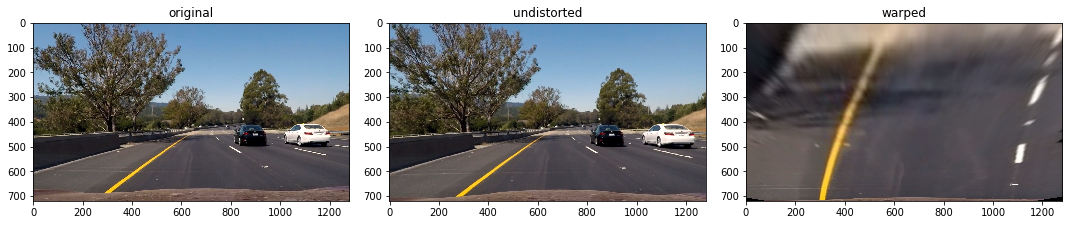

In [31]:
ptransform = calibrate_perspective_transform()

def warp_perspective(image):
  return cv2.warpPerspective(image, ptransform["M"], ptransform["img_size"], flags=cv2.INTER_LINEAR)

def unwarp_perspective(image):
  return cv2.warpPerspective(image, ptransform["Minv"], ptransform["img_size"], flags=cv2.INTER_LINEAR)

image = cv2.imread(BASE_PATH + 'test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ud_image = undistort_image(image)
warped = warp_perspective(ud_image)

plot_images([("original", image), ("undistorted", ud_image), ("warped", warped)])

# Sobel

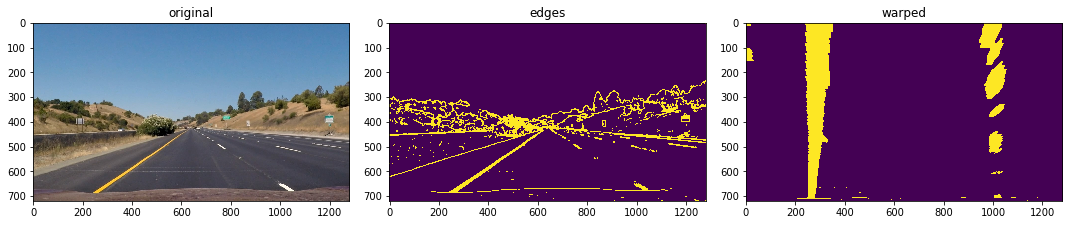

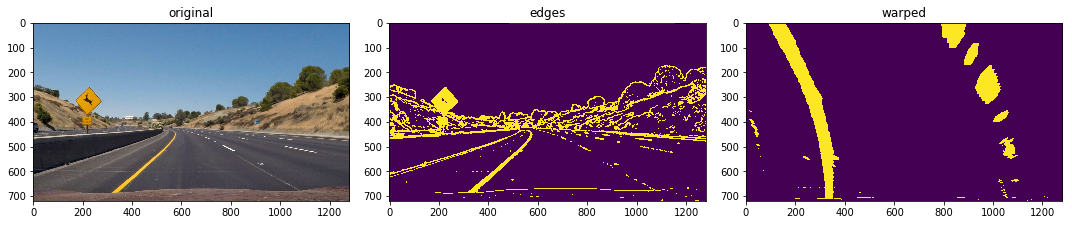

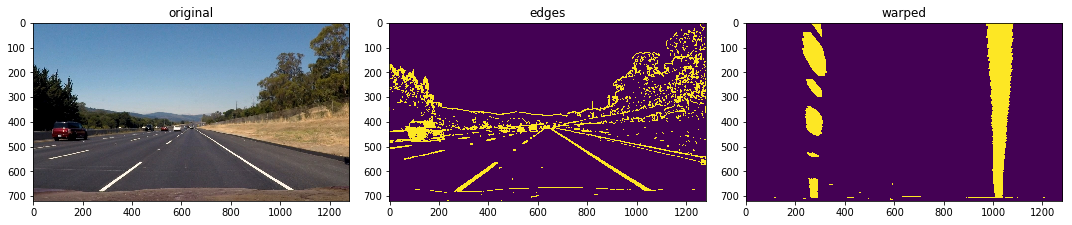

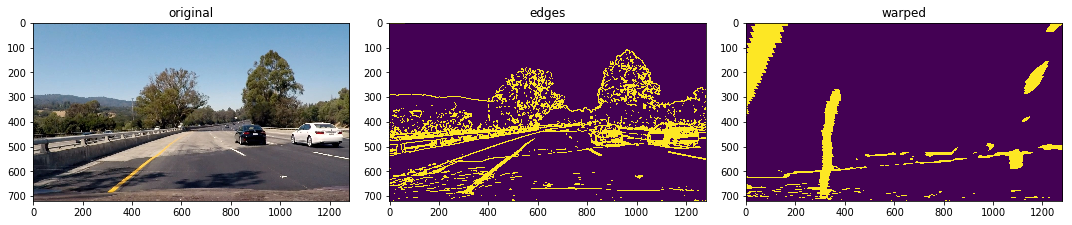

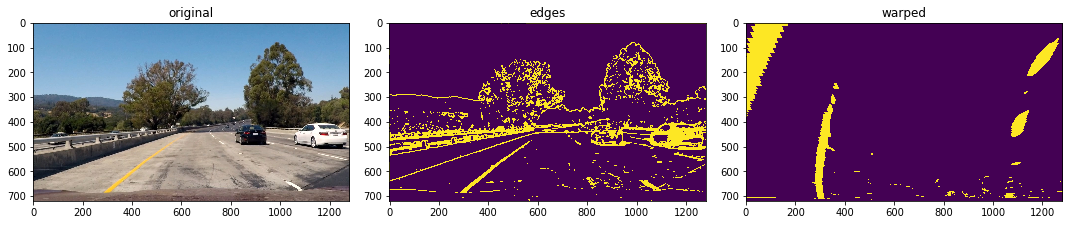

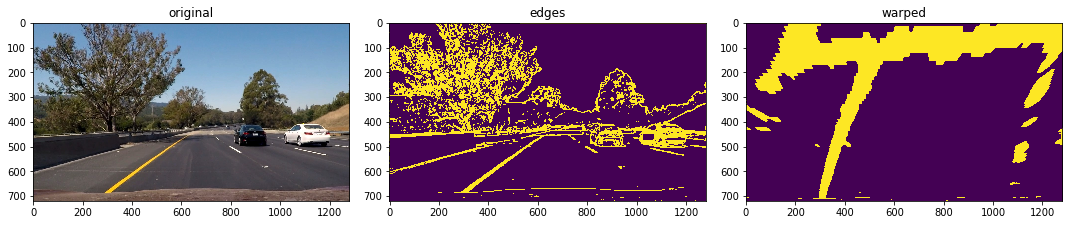

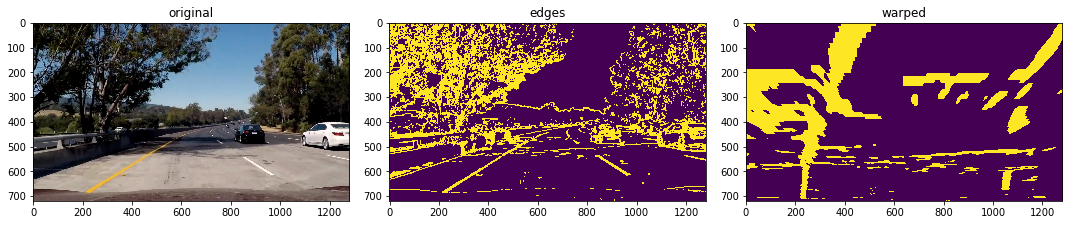

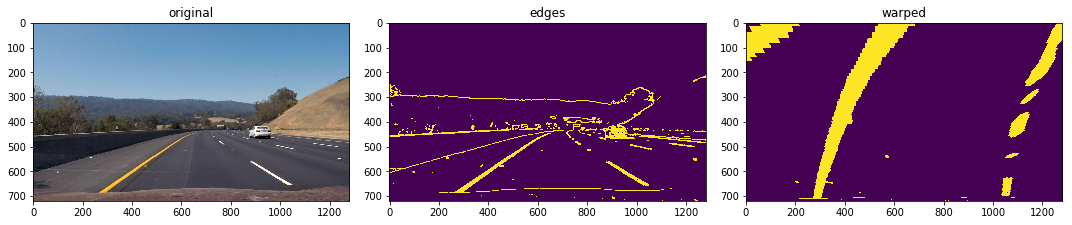

In [32]:
def select_s_channel_thresh(img, thresh=(0, 255)):
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  s_channel = hls[:,:,2]
  binary_output = np.zeros_like(s_channel)
  binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
  return binary_output

# 7.3 Applying Sobel
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, sobel_thresh=(0, 255)):
  # 1) Convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  # 2) Take the derivative in x or y given orient = 'x' or 'y'
  if orient == 'x':
      sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
  elif orient == 'y':
      sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
  # 3) Take the absolute value of the derivative or gradient
  abssobel = np.absolute(sobel)
  # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
  scaled_sobel = np.uint8(255*abssobel/np.max(abssobel))
  # 5) Create a mask of 1's where the scaled gradient magnitude 
  # is > thresh_min and < thresh_max
  binary_output = np.zeros_like(scaled_sobel)
  binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
  # 6) Return this mask as your binary_output image
  return binary_output

# 7.4 Magnitude of the gradient
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
  # 1) Convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  # 2) Take the gradient in x and y separately
  sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
  sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
  # 3) Calculate the magnitude 
  gradmag = np.sqrt(sobelx**2 + sobely**2)
  # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
  scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
  # 5) Create a binary mask where mag thresholds are met
  binary_output = np.zeros_like(scaled_sobel)
  binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
  # 6) Return this mask as your binary_output image
  return binary_output

# 7.5 Direction of the gradient
def dir_thresh(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
  # 1) Convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  # 2) Take the gradient in x and y separately
  sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
  sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
  # 3) Take the absolute value of the x and y gradients
  abs_sobelx = np.absolute(sobelx)
  abs_sobely = np.absolute(sobely)
  # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
  gradir = np.arctan2(abs_sobely, abs_sobelx)
  # 5) Create a binary mask where direction thresholds are met
  binary_output = np.zeros_like(gradir)
  binary_output[(gradir >= dir_thresh[0]) & (gradir <= dir_thresh[1])] = 1
  # 6) Return this mask as your binary_output image
  return binary_output


def resilient_detect_edges(image, sobel_kernel=3):
  # Apply each of the thresholding functions
  gradx = abs_sobel_thresh(image, 'x', sobel_kernel, sobel_thresh=(20, 170))
  grady = abs_sobel_thresh(image, 'y', sobel_kernel, sobel_thresh=(20, 170))
  gradmag = mag_thresh(image, sobel_kernel, mag_thresh=(30, 170))
  graddir = dir_thresh(image, sobel_kernel, dir_thresh=(0, np.pi/2))
  schannel = select_s_channel_thresh(image, thresh=(150, 255))
  combined = np.zeros_like(schannel)
  #combined[((gradx == 1) & (grady == 1)) | (schannel == 1)] = 1
  combined[((gradx == 1) & (grady == 1)) | ((gradmag == 1) & (graddir == 1)) | (schannel == 1)] = 1
  #combined[((gradx == 1)) | ((gradmag == 1) & (graddir == 1)) | (schannel == 1)] = 1
  blur = cv2.GaussianBlur(combined, (sobel_kernel, sobel_kernel), 0)
  return blur

paths = glob.glob(BASE_PATH + "test_images/*.jpg")
images = open_images_from_paths(paths)
for image in images:
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  edges = resilient_detect_edges(image, 7)
  warped = warp_perspective(edges)
  plot_images([("original", image), ("edges", edges), ("warped", warped)])

# Finding Lane Lines

In [33]:
# 15.4 Finding the Lines: Sliding Window
def find_lane_inds_from_scratch(binary_warped):
  # Take a histogram of the bottom half of the image
  histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
  # Create an output image to draw on and visualize the result
  out_img = np.dstack((binary_warped, binary_warped, binary_warped))
  # Find the peak of the left and right halves of the histogram
  # These will be the starting point for the left and right lines
  midpoint = np.int(histogram.shape[0]//2)
  leftx_base = np.argmax(histogram[:midpoint])
  rightx_base = np.argmax(histogram[midpoint:]) + midpoint

  # HYPERPARAMETERS
  # Choose the number of sliding windows
  nwindows = 9
  # Set the width of the windows +/- margin
  margin = 100
  # Set minimum number of pixels found to recenter window
  minpix = 50

  # Set height of windows - based on nwindows above and image shape
  window_height = np.int(binary_warped.shape[0]//nwindows)
  # Identify the x and y positions of all nonzero pixels in the image
  nonzero = binary_warped.nonzero()
  nonzeroy = np.array(nonzero[0])
  nonzerox = np.array(nonzero[1])
  # Current positions to be updated later for each window in nwindows
  leftx_current = leftx_base
  rightx_current = rightx_base

  # Create empty lists to receive left and right lane pixel indices
  left_lane_inds = []
  right_lane_inds = []

  # Step through the windows one by one
  for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                  (win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),
                  (win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identify the nonzero pixels in x and y within the window #
    good_left_inds = ((nonzeroy >= win_y_low) &
                      (nonzeroy < win_y_high) & 
                      (nonzerox >= win_xleft_low) &
                      (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) &
                       (nonzeroy < win_y_high) &
                       (nonzerox >= win_xright_low) &
                       (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
      leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
      rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

  # Concatenate the arrays of indices (previously was a list of lists of pixels)
  #try:
  #  left_lane_inds = np.concatenate(left_lane_inds)
  #  right_lane_inds = np.concatenate(right_lane_inds)
  #except ValueError:
    # Avoids an error if the above is not implemented fully
  #  pass
  left_lane_inds = np.concatenate(left_lane_inds)
  right_lane_inds = np.concatenate(right_lane_inds)

  return left_lane_inds, right_lane_inds, out_img

# 15.5 Find the Lines: Search from Prior
def find_lane_inds_from_previous(binary_warped, left_fit, right_fit):
  # HYPERPARAMETER
  # Choose the width of the margin around the previous polynomial to search
  # The quiz grader expects 100 here, but feel free to tune on your own!
  margin = 100

  # Create an output image to draw on and visualize the result
  out_img = np.dstack((binary_warped, binary_warped, binary_warped))

  # Grab activated pixels
  nonzero = binary_warped.nonzero()
  nonzeroy = np.array(nonzero[0])
  nonzerox = np.array(nonzero[1])
  
  left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                    (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
  right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                     (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
  
  return left_lane_inds, right_lane_inds, out_img

def find_lane_inds(binary_warped, left_fit=[], right_fit=[]):
  if not len(left_fit) or not len(right_fit):
    left_lane_inds, right_lane_inds, out_img = find_lane_inds_from_scratch(binary_warped)
  else:
    left_lane_inds, right_lane_inds, out_img = find_lane_inds_from_previous(binary_warped, left_fit, right_fit)
  #left_lane_inds, right_lane_inds, out_img = find_lane_inds_from_scratch(binary_warped)
  return left_lane_inds, right_lane_inds

def find_lane_pixels(binary_warped, left_fit=[], right_fit=[]):
  left_lane_inds, right_lane_inds = find_lane_inds(binary_warped, left_fit, right_fit)

  # Grab activated pixels
  nonzero = binary_warped.nonzero()
  nonzeroy = np.array(nonzero[0])
  nonzerox = np.array(nonzero[1])

  # Again, extract left and right line pixel positions
  leftx = nonzerox[left_lane_inds]
  lefty = nonzeroy[left_lane_inds] 
  rightx = nonzerox[right_lane_inds]
  righty = nonzeroy[right_lane_inds]

  return leftx, lefty, rightx, righty

def find_lane_fit(leftx, lefty, rightx, righty):
  left_fit = np.polyfit(lefty, leftx, 2)
  right_fit = np.polyfit(righty, rightx, 2)

  return left_fit, right_fit

def find_lane_curvature(leftx, lefty, rightx, righty):
  ploty = np.linspace(0, 719, num=720)# to cover same y-range as image

  # Define y-value where we want radius of curvature
  # We'll choose the maximum y-value, corresponding to the bottom of the image
  y_eval = np.max(ploty)

  ym_per_pix = 30/720 # meters per pixel in y dimension
  xm_per_pix = 3.7/700 # meters per pixel in x dimension

  left_curvature = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
  right_curvature = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

  # Calculation of R_curve (radius of curvature)
  left_curverad = ((1 + (2*left_curvature[0]*y_eval*ym_per_pix + left_curvature[1])**2)**1.5) / np.absolute(2*left_curvature[0])
  right_curverad = ((1 + (2*right_curvature[0]*y_eval*ym_per_pix + right_curvature[1])**2)**1.5) / np.absolute(2*right_curvature[0])

  return left_curverad, right_curverad

def find_lane_fit_and_curve_radius(binary_warped, left_fit=[], right_fit=[]):
  leftx, lefty, rightx, righty = find_lane_pixels(binary_warped, left_fit, right_fit)

  left_fit, right_fit = find_lane_fit(leftx, lefty, rightx, righty)
  left_curverad, right_curverad = find_lane_curvature(leftx, lefty, rightx, righty)

  return left_fit, right_fit, left_curverad, right_curverad

def draw_lane_zone(image, left_fit=[], right_fit=[]):
  # Generate x and y values for plotting
  ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
  left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
  right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

  # Create an image to draw the lines on
  warped = np.uint8(np.zeros_like(image))

  # Recast the x and y points into usable format for cv2.fillPoly()
  pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
  pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
  pts = np.hstack((pts_left, pts_right))

  # Draw the lane onto the warped blank image
  cv2.fillPoly(warped, np.int_([pts]), (0,255, 0))

  # Combine the result with the original image
  unwarped = unwarp_perspective(warped)
  overlay = cv2.addWeighted(image, 1, unwarped, 0.25, 0)
  return overlay

def find_offset_from_center(image, left_fit=[], right_fit=[]):
  xm_per_pix = 3.7/700 # meters per pixel in x dimension
  vehicle_midpoint = image.shape[1]/2
  y = image.shape[0]
  left_lane_pos = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
  right_lane_pos = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
  lane_midpoint = left_lane_pos + (right_lane_pos - left_lane_pos)/2
  return (lane_midpoint - vehicle_midpoint) * xm_per_pix

def draw_additional_info(image, left_fit, right_fit, left_curverad, right_curverad):
  avg_curverad = (left_curverad + right_curverad)/2
  cv2.putText(image,'Radius of Curvature: {:6.2f}m Left: {:6.2f}m Right: {:6.2f}m'.format(avg_curverad, left_curverad, right_curverad),
              (130,60), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2, cv2.LINE_AA)
  offset = find_offset_from_center(image, left_fit, right_fit)
  if offset > 0:
    cv2.putText(image, 'Vehicle is {:6.2f} m right of center'.format(offset), (370,100), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2, cv2.LINE_AA)
  else:
    cv2.putText(image, 'Vehicle is {:6.2f} m left of center'.format(-offset), (370,100), cv2.FONT_HERSHEY_SIMPLEX, 1.0,(0,255,0), 2, cv2.LINE_AA)


#left_fit = []
#right_fit = []
#paths = glob.glob("/content/CarND-Advanced-Lane-Lines/test_images/*.jpg")
#paths = glob.glob("/content/CarND-Advanced-Lane-Lines/sampled/*.jpg")
#images = open_images_from_paths(paths)
#for image in images:
#  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#  ud_image = undistort_image(image)
#  edges = resilient_detect_edges(ud_image, 7)
#  warped = warp_perspective(edges)
#  left_fit, right_fit, left_curverad, right_curverad = find_lane_fit_and_curve_radius(warped, left_fit, right_fit)
#  overlay = draw_lane_zone(ud_image, left_fit, right_fit)
#  draw_additional_info(overlay, left_fit, right_fit, left_curverad, right_curverad)
#  #plot_images([("original", image), ("edges", edges), ("warped", warped), ("overlay", overlay)])
#  plot_images([("original", image), ("overlay", overlay)])

# Image Pipeline

In [34]:
class ImagePipeline:
  def __init__(self):
    self.left_fit = []
    self.right_fit = []
    #self.counter = 0

  def process_image(self, image):
    _left_fit = []
    _right_fit = []
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ud_image = undistort_image(image)
    edges = resilient_detect_edges(ud_image, 7)
    warped = warp_perspective(edges)
    _left_fit, _right_fit, left_curverad, right_curverad = find_lane_fit_and_curve_radius(warped, self.left_fit, self.right_fit)
    overlay = draw_lane_zone(ud_image, _left_fit, _right_fit)
    draw_additional_info(overlay, _left_fit, _right_fit, left_curverad, right_curverad)
    #if self.counter % 10 == 0:
    #  print("Plotting..")
    #  plot_images([("original", image), ("overlay", overlay)])
    #  cv2.imwrite('/content/CarND-Advanced-Lane-Lines/sampled/' + str(self.counter) + ".jpg", image) 
    self.left_fit = _left_fit
    self.right_fit = _right_fit
    #self.counter = self.counter + 1

    return cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)

    #return overlay



# Video Pipeline

In [35]:
from moviepy.editor import VideoFileClip

def process_video(invf):
  fname, extn = os.path.splitext(invf)
  ipipe = ImagePipeline()
  iv = VideoFileClip(invf)
  ov = iv.fl_image(ipipe.process_image)
  #ov = iv.fl_image(process_image)
  outvf = fname + "_processed" + extn
  ov.write_videofile(outvf, audio=False)


process_video(BASE_PATH + 'project_video.mp4')

[MoviePy] >>>> Building video ./project_video_processed.mp4
[MoviePy] Writing video ./project_video_processed.mp4



 12%|█▏        | 152/1261 [00:55<08:00,  2.31it/s]


 24%|██▍       | 303/1261 [01:53<06:06,  2.62it/s]


 36%|███▌      | 454/1261 [02:52<05:07,  2.62it/s]


 48%|████▊     | 605/1261 [03:52<04:29,  2.43it/s]


 60%|█████▉    | 756/1261 [04:52<03:18,  2.54it/s]


 72%|███████▏  | 907/1261 [05:51<02:17,  2.57it/s]


 84%|████████▍ | 1057/1261 [06:52<01:29,  2.28it/s]


 96%|█████████▌| 1205/1261 [07:52<00:22,  2.45it/s]


100%|█████████▉| 1260/1261 [08:14<00:00,  2.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_processed.mp4 



# Video Playback

In [ ]:
from IPython.display import HTML

HTML("""
<video width="320" height="240" controls>
  <source src="project_video_processed.mp4" type="video/mp4">
</video>
""")
